In [1]:
library(tidyverse);library(reshape2);library(cowplot);library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“package ‘cowplot’ was built under R version 3.6.3”
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



ERROR: Error in library(patchwork): there is no package called ‘patchwork’


In [ ]:
# Import raw ASV table and check base stats
counts <- read.delim("data-input/CountTable-wtax-bylevel-2020-02-23.txt");head(counts)
stats <- read.delim("data-input/Output_stats.txt", sep=" "); head(stats)
stats$SAMPLE <- row.names(stats)
stats_l <- melt(stats)
# head(stats_l)
# unique(stats_l$variable)
#
ggplot(stats_l, aes(x=SAMPLE, y=value, fill=variable)) +
    geom_bar(stat="identity")+
    facet_grid(variable~., scales="free")+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=90, hjust=1,vjust=0.5))

# Gather columns
counts_gathered <- gather(counts, SAMPLE, COUNT, Axial_Anemone_FS891_2013:Siders_Surface_MARCH_2019, factor_key=TRUE)
# head(counts_gathered)
# unique(counts_gathered$SAMPLE)
#
# Split columns to start parsing data sets
x <- colsplit(counts_gathered$SAMPLE, "_", c("DATASET", "LOCATION", "SAMPLEID", "YEAR", "REP")); counts_gathered_wIDs <- data.frame(x, counts_gathered)
#
head(counts_gathered_wIDs)
counts_gathered_wIDs$DATASET <- gsub("GordaRdige","GordaRidge", counts_gathered_wIDs$DATASET)
counts_gathered_wIDs$SAMPLE <- gsub("GordaRdige_Vent090_T24_2019", "GordaRidge_Vent090_T24_2019", counts_gathered_wIDs$SAMPLE)
#
counts_gathered_plots <- subset(counts_gathered_wIDs, COUNT > 0)
# Summarize sequence counts to Level2
counts_by_lev2 <- counts_gathered_plots %>%
    group_by(SAMPLE, level1, level2) %>%
    summarise(SUM = sum(COUNT)) %>%
    as.data.frame

# Quick overview of ASV results
ggplot(counts_by_lev2, aes(x=SAMPLE, y=SUM, fill = level2)) +
    geom_bar(stat="identity", position="fill")+
    coord_flip()

unique(counts_gathered_plots$DATASET)
siders_tagseq_counts <- subset(counts_gathered_plots, DATASET %in% "Siders" | LOCATION %in% "ExtractControl")
# View(siders_tagseq_counts)
# save(siders_tagseq_counts, file="Siders-tagseq-dataframe-26022020.RData")
axial_tagseq_counts <- subset(counts_gathered_plots, DATASET %in% "Axial" | LOCATION %in% "ExtractControl")
# save(axial_tagseq_counts, file="Axial-tagseq-dataframe-2602020.RData")
GR_tagseq_counts <- subset(counts_gathered_plots, DATASET %in% "GordaRidge" | LOCATION %in% "ExtractControl")
unique(GR_tagseq_counts$SAMPLE)

In [3]:
install.packages("decontam")

Warning message:
“package ‘decontam’ is not available (for R version 3.6.1)”

## Clean ASV table with 'decontam' in phyloseq

In [2]:
library(phyloseq);library(decontam)

ERROR: Error in library(decontam): there is no package called ‘decontam’


ERROR: Error in library(DivNet): there is no package called ‘DivNet’


In [ ]:
# Run decontam protocol
# Formatting: fix blank entries, widen data frame
GR_tagseq_counts$level2 <- sub("^$", "Unassigned", GR_tagseq_counts$level2) #Fill "blank" taxonomy assignments with "Unassigned"
head(GR_tagseq_counts)
tmp <- GR_tagseq_counts[, c("Feature.ID", "SAMPLE", "COUNT")]
tmp$COUNT<-as.numeric(tmp$COUNT)
tmp_tax <- GR_tagseq_counts[, c("Taxon", "level1", "level2", "level3", "level4", "level5", "level6","Feature.ID", "SAMPLE", "COUNT")]
# head(tmp_tax)
asvtab <- dcast(tmp, Feature.ID ~ SAMPLE, fill = 0)
taxmat_tmp <- as.matrix(dcast(tmp_tax, Feature.ID+Taxon+level1+level2+level3+level4+level5+level6+level6~SAMPLE))
taxmat <- taxmat_tmp[, c("Taxon", "level1", "level2", "level3", "level4", "level5", "level6")]

# Set up data to be imported into phyloseq
# Rownames = feature.id
row.names(asvtab)<-asvtab$Feature.ID
colnames(asvtab)
asvtab <- asvtab[2:35]
# head(asvtab); names(asvtab)
asvmat <- as.matrix(asvtab) #convert to matrix

# link up row names for each matrix
row.names(taxmat)<-row.names(asvmat)
# head(taxmat)
#
class(asvmat);class(taxmat)
colnames(taxmat)
ASV = otu_table(asvmat, taxa_are_rows = TRUE) #phyloseq command
TAX = tax_table(taxmat)
physeq <- phyloseq(ASV, TAX)
physeq #Phyloseq object

# Include additional sample names
samplenames <- as.data.frame(colnames(asvtab))
samplenames; head(asvtab)
colnames(samplenames)[1]<-"SAMPLE"

# Import metadata
ventnames <- read.delim("ventnames-gordaridge.txt")
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
samplenames_1 <- left_join(samplenames, ventnames)
head(samplenames_1)
# View(samplenames_1)
row.names(samplenames_1)<-sample_names(physeq)

# Convert to phyloseq object
sampledata <- sample_data(samplenames_1); sampledata
# Merge with other data
physeq_names = merge_phyloseq(physeq, sampledata)
physeq_names
sample_data(physeq_names)

# Decontam:
physeq_names
# Check out library size of my data
df <- as.data.frame(sample_data(physeq_names))
df$LibrarySize <- sample_sums(physeq_names)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))
#
ggplot(data=df, aes(x=Index, y=LibrarySize, fill=Sample_or_Control, shape=LOCATION)) + 
  geom_point(color="black", size=3, aes(shape=LOCATION)) +
  scale_shape_manual(values = c(21,22,23)) +
  theme_bw()
# Shows that out of the 3 ship blanks I have, one of the sames has a pretty large library size, otherwise, control samples have very small library sizes.

sample_data(physeq_names)
# assign negative control designation
sample_data(physeq_names)$is.neg <- sample_data(physeq_names)$Sample_or_Control == "Control Sample"

# ID contaminants
## Using Prevalence information
contamdf.prev <- isContaminant(physeq_names, method="prevalence", neg="is.neg", threshold = 0.5, normalize = TRUE) # 0.5 - this threshold will ID contaminants in all samples that are more prevalent in negative controls than in positive samplese
# ?isContaminant()
table(contamdf.prev$contaminant) # 34 seqs identified as contaminants
which(contamdf.prev$contaminant)

# Make phyloseq object of presence-absence in negative controls and true samples
## change to presence absence
gr.pa <- transform_sample_counts(physeq_names, function(abund) 1*(abund>0))

# isolate PA of positive and negative samples
gr.pa.neg <- prune_samples(sample_data(gr.pa)$Sample_or_Control == "Control Sample", gr.pa)
gr.pa.pos <- prune_samples(sample_data(gr.pa)$Sample_or_Control == "True Sample", gr.pa)
                                 
                                 # Extracting contaminants:
table(contamdf.prev$contaminant) # 34 seqs identified as contaminants
which(contamdf.prev$contaminant)
head(contamdf.prev)

# Subset TRUE contaminants
contams <- subset(contamdf.prev, contaminant == "TRUE")
contams$Feature.ID <- row.names(contams)
head(contams);dim(contams)
list_of_contams <- as.character(contams$Feature.ID)
#
# Explore taxa IDed as contaminants
taxa_list <- as.data.frame(taxmat)
taxa_list$Feature.ID <- row.names(taxa_list)
head(taxa_list)
taxa_contams <- left_join(contams, taxa_list)
# write_delim(taxa_contams, path = "List-of-contaminant-ASVs.txt", delim = "\t")


# Plot total sequences and which are contaminants
# Remove contaminant and count sequence sums per sample to see which samples had the highest number of contamiant sequences removed.
# After remove contaminants, what % of sequences is removed?
head(GR_tagseq_counts[1:2,])
GR_tagseq_counts$CONTAM <- "Pass"
# head(contams[1:2,])
str(list_of_contams)
GR_tagseq_counts$CONTAM[GR_tagseq_counts$Feature.ID %in% list_of_contams] = "Fail"
head(GR_tagseq_counts[1:2,])

# Make character list of all feature.ids to KEEP:
keep1<- subset(GR_tagseq_counts, CONTAM %in% "Pass")
length(unique(keep1$Feature.ID))
keep_asvs <- as.character(unique(keep1$Feature.ID)) #see below
#
passfail <- GR_tagseq_counts %>%
  group_by(SAMPLE, CONTAM) %>%
  summarise(SUM_CONTAM = sum(COUNT)) %>%
  data.frame
head(passfail[1:2,])
#
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
passfail_wID <- left_join(passfail, ventnames, by = "SAMPLE")
head(passfail_wID)

locations <- c("", "Shipblank","Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Candelabra Vent", "SirVentsAlot Vent", "Venti Latte Vent")
passfail_wID$LOCATION_ORDER <- factor(passfail_wID$LocationName, levels = locations)
#
contam_plot <- ggplot(passfail_wID, aes(x=SAMPLE, y=SUM_CONTAM, fill=CONTAM))+
  geom_bar(stat = "identity", color="black")+
  scale_fill_manual(values = c("#e34a33", "#3182bd"))+
  coord_flip()+
  labs(x="", y="Total sequences")+
  theme_minimal()+
  theme(legend.position = "top", strip.text.y = element_text(angle=0, color="black"), axis.text = element_text(color="black", face="bold"))+
  scale_y_continuous(expand=c(0,0))+
  facet_grid(LOCATION_ORDER~., scales = "free", space="free")
# svg("GR-seq-contamination-breakdown.svg",w=13,h=6)
plot_grid(contam_plot, contam_plot+scale_y_log10()+labs(y="Log(total sequences)"), labels = c("a", "b"))
# dev.off()


# Get number information:
# Total sequences:
head(GR_tagseq_counts); sum(GR_tagseq_counts$COUNT) #1.57 million reads

# If we remove all the control samples:
unique(GR_tagseq_counts$SAMPLEID)
GR_tagseq_counts_noCTRL <- subset(GR_tagseq_counts, !(SAMPLEID %in% "CTRL"))
sum(GR_tagseq_counts_noCTRL$COUNT) # 1.48 million reads

# Remove contaminants:
counts_decont <- subset(GR_tagseq_counts, !(Feature.ID %in% list_of_contams))
dim(GR_tagseq_counts); dim(counts_decont) #34 lines removed
colnames(counts_decont)
100*(1-(sum(counts_decont$COUNT)/sum(GR_tagseq_counts_noCTRL$COUNT)))
# 1.24% of sequences was removed following decontam; this is counting the ship blank samples themselves

# Breakdown by samples:
head(passfail)
passfail_wide <- dcast(passfail, SAMPLE ~ CONTAM)
passfail_wide$PercLossSeq <- paste(100*(passfail_wide$Fail/(passfail_wide$Fail+passfail_wide$Pass)))
dim(passfail_wide)
write.csv(passfail_wide, file="PercSeqLost-decontam.csv")
# breakdown by sample - reports % lost per sample

# Remove contaminant sequences from phyloseq object:
# Subset TRUE contaminants
# ?prune_taxa
class(keep_asvs)
physeq_tmp <- prune_taxa(keep_asvs, physeq_names)
sample_data(physeq_tmp)

# Remove one sample with too few sequences
physeq_clean <- subset_samples(physeq_tmp, sample_names(physeq_tmp) !="GordaRidge_BSW020_sterivex_2019_REPa")
sample_data(physeq_clean)

# SAMPLE, LOCATION_SPECIFIC, LocationName
colnames(taxmat)

# Remove control samples from data frame
head(GR_tagseq_counts)
tmp <- subset(GR_tagseq_counts, !(SAMPLEID %in% "CTRL")) # Remove controls, get list of sample names that are controls
samples_keep <- as.character(unique(tmp$SAMPLE))
physeq_clean_true <- prune_samples(samples_keep, physeq_clean)
#
physeq_clean_true %>% sample_data %>% head

# Save these R Objects
# save(physeq_clean, physeq_clean_true, file="phyloseq-objects.RData")
save(counts_decont, file="GR-ASV-table-clean-26-02-2020.RData")

In [5]:
load("data-input/GR-ASV-table-clean-26-02-2020.RData", verbose=TRUE) # after decontam clenaing
head(counts_decont)
#
gr_counts <- subset(counts_decont, COUNT > 0 & DATASET %in% "GordaRidge")
# head(gr_counts)
gr_counts$level2 <- sub("^$", "Unassigned", gr_counts$level2)
# head(gr_counts[1:3,])
#
# Import metadata for sample names & Join
ventnames <- read.delim("data-input/ventnames-gordaridge.txt")
names(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
gr_counts_name <- left_join(gr_counts, ventnames[c(1,3,5:6)])
gr_counts_name$LocationName[gr_counts_name$LOCATION == "Shipblank"]="Shipblank"

Loading objects:
  counts_decont


,DATASET,LOCATION,SAMPLEID,YEAR,REP,Feature.ID,Taxon,Confidence,level1,level2,level3,level4,level5,level6,level7,SAMPLE,COUNT,CONTAM
87172,Axial,ExtractControl,CTRL,2019,,2fa21026b4047e354f119a43c0341a65,Eukaryota;Opisthokonta,0.7041164,Eukaryota,Opisthokonta,,,,,,Axial_ExtractControl_CTRL_2019,1520,Pass
87273,Axial,ExtractControl,CTRL,2019,,01d46e90107929f3903e4b5bff58a630,Eukaryota,1.0000000,Eukaryota,Unassigned,,,,,,Axial_ExtractControl_CTRL_2019,31,Pass
88999,Axial,ExtractControl,CTRL,2019,,6d4984d3004dc93a767b711fce76c22a,Eukaryota,1.0000000,Eukaryota,Unassigned,,,,,,Axial_ExtractControl_CTRL_2019,96,Pass
89193,Axial,ExtractControl,CTRL,2019,,7f345942b109d8107ed8748e752b3b67,Eukaryota;Opisthokonta;Metazoa;Rotifera;Rotifera_X;Rotifera_XX;Rotaria;Rotaria_rotatoria;,0.8935792,Eukaryota,Opisthokonta,Metazoa,Rotifera,Rotifera_X,Rotifera_XX,Rotaria;Rotaria_rotatoria;,Axial_ExtractControl_CTRL_2019,81,Pass
90196,Axial,ExtractControl,CTRL,2019,,7ba8f74df1b3dcb5c010795eb26bac7f,Eukaryota;Archaeplastida;Streptophyta;Embryophyceae;Embryophyceae_X;Embryophyceae_XX,0.9998972,Eukaryota,Archaeplastida,Streptophyta,Embryophyceae,Embryophyceae_X,Embryophyceae_XX,,Axial_ExtractControl_CTRL_2019,39,Pass
90635,Axial,ExtractControl,CTRL,2019,,5a2177bb7499febc60184a6a15dd3a9c,Eukaryota;Alveolata;Ciliophora;Oligohymenophorea;Scuticociliatia_2;Pleuronematida;Pleuronema,0.9484855,Eukaryota,Alveolata,Ciliophora,Oligohymenophorea,Scuticociliatia_2,Pleuronematida,Pleuronema,Axial_ExtractControl_CTRL_2019,30,Pass


[1] "SAMPLENAME"        "LOCATION"          "LOCATION_SPECIFIC"
[4] "SAMPLEID"          "Sampletype"        "LocationName"     
[7] "Sample_or_Control" "Sample_or_BSW"

Joining, by = "SAMPLE"


In [ ]:
# Revise & explore taxonomy
hist(gr_counts_name$COUNT)
hist(log(gr_counts_name$COUNT))
#
pr2_rename_taxa_w2<-function(split){
  split$Taxa<-"Unassigned"
  split$Taxa[split$level2 == ""]="No best hit"
  split$Taxa[split$level2 == "Alveolata"]="Alveolata-Other"
  split$Taxa[split$level3 == "Ciliophora"]="Alveolata-Ciliates"
  split$Taxa[split$level3 == "Dinoflagellata"]="Alveolata-Dinoflagellates"
  # split$Taxa[split$level3 == "Apicomplexa"]="Alveolata-Apicomplexa"
  #
  split$Taxa[split$level2 == "Hacrobia"]="Hacrobia-Other"
  split$Taxa[split$level3 == "Cryptophyta"]="Hacrobia-Cryptophyta"
  split$Taxa[split$level3 == "Haptophyta"]="Hacrobia-Haptophyta"
  split$Taxa[split$level3 == "Katablepharidophyta"]="Hacrobia-Katablepharidophyta"
  # split$Taxa[split$level3 == "Telonemia"]="Hacrobia-Telonemia"
  #
  split$Taxa[split$level2 == "Opisthokonta"]="Opisthokonta-Other"
  split$Taxa[split$level3 == "Fungi"]="Opisthokonta-Fungi"
  split$Taxa[split$level3 == "Metazoa"]="Opisthokonta-Metazoa"
  #
  split$Taxa[split$level2 == "Stramenopiles"]="Stramenopiles-Other"
  split$Taxa[split$level3 == "Ochrophyta"]="Stramenopiles-Ochrophyta"
  split$Taxa[split$level3 == "Pseudofungi"]="Stramenopiles-Pseudofungi"
  split$Taxa[split$level3 == "Sagenista"]="Stramenopiles-Sagenista"
  #
  split$Taxa[split$level2 == "Archaeplastida"]="Archaeplastida-Other"
  split$Taxa[split$level3 == "Chlorophyta"]="Archaeplastida-Chlorophyta"
  split$Taxa[split$level3 == "Streptophyta"]="Archaeplastida-Streptophyta"
  #
  split$Taxa[split$level2 == "Excavata"]="Excavata"
  # split$Taxa[split$level3 == "Metamonada"]="Excavata-Metamonada"
  #
  split$Taxa[split$level2 == "Amoebozoa"]="Other"
  # split$Taxa[split$level3 == "Lobosa"]="Amoebozoa-Lobosa"
  #
  split$Taxa[split$level2 == "Rhizaria"]="Rhizaria"
  # split$Taxa[split$level3 == "Cercozoa"]="Rhizaria-Cercozoa"
  return(split)
}
#
gr_counts_wtax <- pr2_rename_taxa_w2(gr_counts_name)
head(gr_counts_wtax)

In [ ]:
# Remove control - blank samples.
gr_counts_wtax_samplesonly <- subset(gr_counts_wtax, !(Sampletype == "control"))

## To average across replicates, modify SUPR sample names
gr_counts_filter <- gr_counts_wtax_samplesonly
gr_counts_filter$SAMPLEID<- sub("SUPRS9", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS11", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS10", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS2", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS3", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS1", "SUPR", gr_counts_filter$SAMPLEID)

# Average across replicates
colnames(gr_counts_filter)
gr_counts_avg_wtax <- gr_counts_filter %>%
  group_by(Feature.ID, SAMPLEID, Sampletype,  LOCATION_SPECIFIC, LocationName, Taxon, level1, level2, level3, level4, level5, level6, level7, Taxa) %>%
  summarise(COUNT_AVG = mean(COUNT)) %>%
  as.data.frame
# dim(gr_counts_filter);dim(gr_counts_avg_wtax)
# head(gr_counts_avg_wtax)
# unique(gr_counts_avg_wtax$Taxa)

# save(gr_counts_filter,gr_counts_wtax, gr_counts_avg_wtax, file="GordaRidge-ASVtable-avg-26-02-2020.RData")

## Ordination analysis - PCoA

In [8]:
load("data-input/GordaRidge-ASVtable-avg-26-02-2020.RData")
library(reshape2); 
library(vegan); 
library(dplyr)
library(ade4); 
library(compositions); 
library(tidyverse)
library(purrr)
library(cluster)
library(RColorBrewer)
library(ape)

# Remove controls
gr_counts_allsamples <- subset(counts_decont, !(SAMPLEID == "CTRL"))
gr_nums <- gr_counts_allsamples[, c("Feature.ID", "SAMPLE", "COUNT")]
tax <- gr_counts_allsamples[, c("Feature.ID", "Taxon")]
unique(gr_nums$SAMPLE)
gr_nums_filter <- subset(gr_nums, !(SAMPLE == "GordaRidge_BSW020_sterivex_2019_REPa"))
gr_nums_wide <- dcast(gr_nums_filter, Feature.ID~SAMPLE, fill=0)
row.names(gr_nums_wide)<-gr_nums_wide$Feature.ID; gr_nums_wide$Feature.ID<-NULL

[1] "GordaRidge_Vent090_T24_2019"           
 [2] "GordaRidge_BSW020_sterivex_2019_REPa"  
 [3] "GordaRidge_BSW056_sterivex_2019_REPb"  
 [4] "GordaRidge_BSW081_sterivex_2019"       
 [5] "GordaRidge_Plume001_sterivex_2019_REPa"
 [6] "GordaRidge_Plume001_sterivex_2019_REPb"
 [7] "GordaRidge_Plume001_T0_2019_REP12"     
 [8] "GordaRidge_Plume001_T0_2019_REP34"     
 [9] "GordaRidge_Plume001_T24_2019_REP12"    
[10] "GordaRidge_Plume001_T36_2019_REP12"    
[11] "GordaRidge_Plume036_sterivex_2019_REPb"
[12] "GordaRidge_Plume096_sterivex_2019"     
[13] "GordaRidge_Vent009_SUPRS1_2019"        
[14] "GordaRidge_Vent010_SUPRS2_2019"        
[15] "GordaRidge_Vent011_SUPRS3_2019"        
[16] "GordaRidge_Vent013_T0_2019_REP13"      
[17] "GordaRidge_Vent013_T36_2019_REP12"     
[18] "GordaRidge_Vent013_T36_2019_REP34"     
[19] "GordaRidge_Vent039_SUPRS1_2019"        
[20] "GordaRidge_Vent040_SUPRS2_2019"        
[21] "GordaRidge_Vent041_SUPRS3_2019"        
[22] "GordaRidge_Vent043_T0_2019_REP13"      
[23] "GordaRidge_Vent043_T36_2019_REP13"     
[24] "GordaRidge_Vent086_SUPRS1_2019"        
[25] "GordaRidge_Vent087_SUPRS2_2019"        
[26] "GordaRidge_Vent088_SUPRS3_2019"        
[27] "GordaRidge_Vent105_SUPRS9_2019"        
[28] "GordaRidge_Vent106_SUPRS10_2019"       
[29] "GordaRidge_Vent107_SUPRS11_2019"       
[30] "GordaRidge_Vent110_T24_2019"

Using COUNT as value column: use value.var to override.


[1] 0.07925836 0.07736303 0.06910714 0.05734696 0.05188187 0.04898675

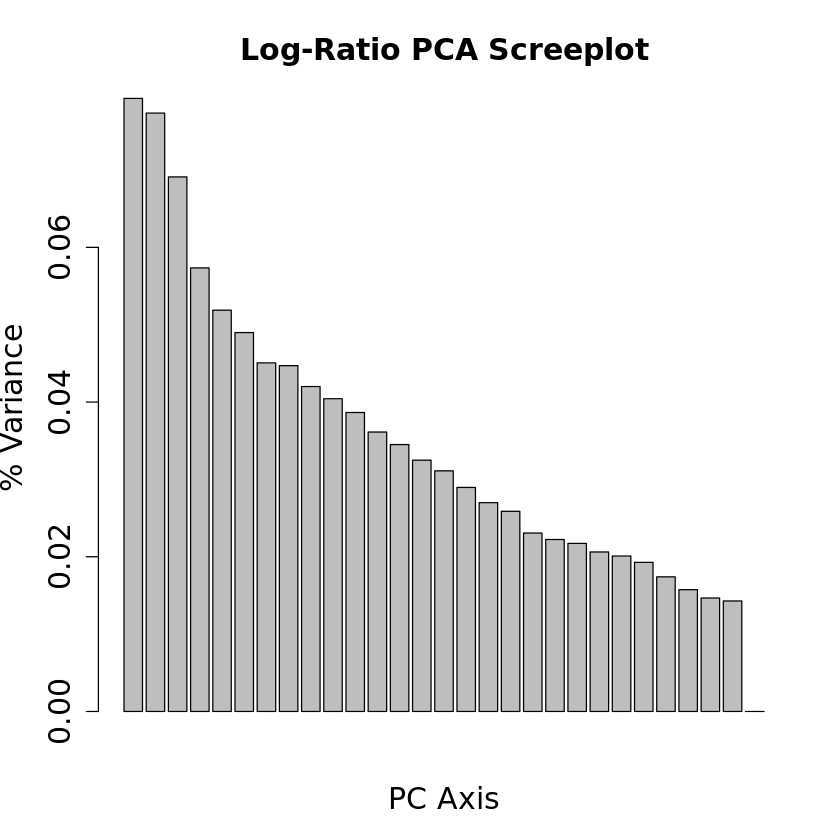

In [9]:
# Transform data
# Log-ratio
log_rats<-data.frame(compositions::ilr(t(gr_nums_wide)))

# look at eigenvalues
pca_lr <- prcomp(log_rats)
variance_lr <- (pca_lr$sdev^2)/sum(pca_lr$sdev^2)
head(variance_lr)
barplot(variance_lr,
        main='Log-Ratio PCA Screeplot',
        xlab='PC Axis',
        ylab='% Variance',
        cex.names=1.5,cex.axis=1.5,cex.lab=1.5,cex.main=1.5)
# Based on this screeplot - 2 axis are OK, as they show 0.079 and 0.77, respectively, of the variance.

,DATASET,LOCATION,SAMPLEID,YEAR,REP,PC1,PC2,PC3,PC4,PC5,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,SAMPLE
GordaRidge_BSW056_sterivex_2019_REPb,GordaRidge,BSW056,sterivex,2019,REPb,11.709389,-4.704151,2.737196,-8.950505,0.7717585,...,-0.8848246,-0.362220416,0.1259532,0.92987160,0.0551194,-1.108406,-0.62564722,0.7323156,4.260481e-15,GordaRidge_BSW056_sterivex_2019_REPb
GordaRidge_BSW081_sterivex_2019,GordaRidge,BSW081,sterivex,2019,,15.878746,-18.812480,-35.528861,14.460101,16.5079805,...,-0.2628994,-0.002304058,0.2914215,-0.05225868,-0.1909242,-1.079920,0.09384105,-0.2252023,2.720046e-15,GordaRidge_BSW081_sterivex_2019
GordaRidge_Plume001_sterivex_2019_REPa,GordaRidge,Plume001,sterivex,2019,REPa,-11.359841,10.619441,-5.567615,-3.120014,-3.3694670,...,-0.5832622,-7.039405724,16.7965382,2.43917307,-0.9107024,1.711047,-0.53084618,-0.5753389,2.720046e-15,GordaRidge_Plume001_sterivex_2019_REPa
GordaRidge_Plume001_sterivex_2019_REPb,GordaRidge,Plume001,sterivex,2019,REPb,-9.989269,8.590890,-5.787346,-3.182868,-3.6106845,...,-0.7789751,8.525827574,-18.2427468,-1.14877416,0.1494977,-1.149185,0.26791409,-0.2838290,2.761680e-15,GordaRidge_Plume001_sterivex_2019_REPb
GordaRidge_Plume001_T0_2019_REP12,GordaRidge,Plume001,T0,2019,REP12,-9.727408,3.212840,-7.166445,-5.286687,-2.1055426,...,2.2891633,-11.157809340,-6.4437809,19.10665387,-4.1461793,-1.588999,-3.13147931,-1.8965622,3.896189e-15,GordaRidge_Plume001_T0_2019_REP12
GordaRidge_Plume001_T0_2019_REP34,GordaRidge,Plume001,T0,2019,REP34,-10.501124,4.961117,-8.027975,-5.691631,-3.7971881,...,2.2923028,20.061086812,8.2909583,1.41185873,1.5929407,-1.101488,-1.76430123,-1.1791502,2.938622e-15,GordaRidge_Plume001_T0_2019_REP34


[1] "SAMPLENAME"        "LOCATION"          "LOCATION_SPECIFIC"
[4] "SAMPLEID"          "Sampletype"        "LocationName"     
[7] "Sample_or_Control" "Sample_or_BSW"

SAMPLENAME,LOCATION,LOCATION_SPECIFIC,SAMPLEID,Sampletype,LocationName,Sample_or_Control,Sample_or_BSW
Axial_ExtractControl_CTRL_2019,ExtractControl,ExtractControl,CTRL,Control,Lab blank,Control Sample,Control
GordaRidge_Plume001_T0_2019_REP12,GordaRidge,Plume001,T0,Grazing,Mt Edwards Plume,True Sample,True Sample
GordaRidge_Plume001_T24_2019_REP12,GordaRidge,Plume001,T24,Grazing,Mt Edwards Plume,True Sample,True Sample
GordaRidge_Plume001_T36_2019_REP12,GordaRidge,Plume001,T36,Grazing,Mt Edwards Plume,True Sample,True Sample
GordaRidge_Vent013_T0_2019_REP13,GordaRidge,Vent013,T0,Grazing,Mt Edwards Vent,True Sample,True Sample
GordaRidge_Vent013_T36_2019_REP12,GordaRidge,Vent013,T36,Grazing,Mt Edwards Vent,True Sample,True Sample


DATASET,LOCATION.x,SAMPLEID.x,YEAR,REP,PC1,PC2,PC3,PC4,PC5,...,PC28,PC29,SAMPLE,LOCATION.y,LOCATION_SPECIFIC,SAMPLEID.y,Sampletype,LocationName,Sample_or_Control,Sample_or_BSW
GordaRidge,BSW056,sterivex,2019,REPb,11.709389,-4.704151,2.737196,-8.950505,0.7717585,...,0.7323156,4.260481e-15,GordaRidge_BSW056_sterivex_2019_REPb,GordaRidge,BSW056,sterivex,in situ,Deep seawater,True Sample,BSW
GordaRidge,BSW081,sterivex,2019,,15.878746,-18.812480,-35.528861,14.460101,16.5079805,...,-0.2252023,2.720046e-15,GordaRidge_BSW081_sterivex_2019,GordaRidge,BSW081,sterivex,in situ,Shallow seawater,True Sample,BSW
GordaRidge,Plume001,sterivex,2019,REPa,-11.359841,10.619441,-5.567615,-3.120014,-3.3694670,...,-0.5753389,2.720046e-15,GordaRidge_Plume001_sterivex_2019_REPa,GordaRidge,Plume001,sterivex,in situ,Mt Edwards Plume,True Sample,True Sample
GordaRidge,Plume001,sterivex,2019,REPb,-9.989269,8.590890,-5.787346,-3.182868,-3.6106845,...,-0.2838290,2.761680e-15,GordaRidge_Plume001_sterivex_2019_REPb,GordaRidge,Plume001,sterivex,in situ,Mt Edwards Plume,True Sample,True Sample
GordaRidge,Plume001,T0,2019,REP12,-9.727408,3.212840,-7.166445,-5.286687,-2.1055426,...,-1.8965622,3.896189e-15,GordaRidge_Plume001_T0_2019_REP12,GordaRidge,Plume001,T0,Grazing,Mt Edwards Plume,True Sample,True Sample
GordaRidge,Plume001,T0,2019,REP34,-10.501124,4.961117,-8.027975,-5.691631,-3.7971881,...,-1.1791502,2.938622e-15,GordaRidge_Plume001_T0_2019_REP34,GordaRidge,Plume001,T0,Grazing,Mt Edwards Plume,True Sample,True Sample


[1] Deep seawater     Shallow seawater  Mt Edwards Plume  Mt Edwards Vent  
[5] Venti Latte Vent  Candelabra Vent   SirVentsAlot Vent
9 Levels: Candelabra Vent Deep seawater Lab blank ... Venti Latte Vent

DATASET,LOCATION.x,SAMPLEID.x,YEAR,REP,PC1,PC2,PC3,PC4,PC5,...,PC29,SAMPLE,LOCATION.y,LOCATION_SPECIFIC,SAMPLEID.y,Sampletype,LocationName,Sample_or_Control,Sample_or_BSW,SAMPLE_ORDER
GordaRidge,BSW056,sterivex,2019,REPb,11.709389,-4.704151,2.737196,-8.950505,0.7717585,...,4.260481e-15,GordaRidge_BSW056_sterivex_2019_REPb,GordaRidge,BSW056,sterivex,in situ,Deep seawater,True Sample,BSW,Deep seawater
GordaRidge,BSW081,sterivex,2019,,15.878746,-18.812480,-35.528861,14.460101,16.5079805,...,2.720046e-15,GordaRidge_BSW081_sterivex_2019,GordaRidge,BSW081,sterivex,in situ,Shallow seawater,True Sample,BSW,Shallow seawater
GordaRidge,Plume001,sterivex,2019,REPa,-11.359841,10.619441,-5.567615,-3.120014,-3.3694670,...,2.720046e-15,GordaRidge_Plume001_sterivex_2019_REPa,GordaRidge,Plume001,sterivex,in situ,Mt Edwards Plume,True Sample,True Sample,Mt Edwards Plume
GordaRidge,Plume001,sterivex,2019,REPb,-9.989269,8.590890,-5.787346,-3.182868,-3.6106845,...,2.761680e-15,GordaRidge_Plume001_sterivex_2019_REPb,GordaRidge,Plume001,sterivex,in situ,Mt Edwards Plume,True Sample,True Sample,Mt Edwards Plume
GordaRidge,Plume001,T0,2019,REP12,-9.727408,3.212840,-7.166445,-5.286687,-2.1055426,...,3.896189e-15,GordaRidge_Plume001_T0_2019_REP12,GordaRidge,Plume001,T0,Grazing,Mt Edwards Plume,True Sample,True Sample,Mt Edwards Plume
GordaRidge,Plume001,T0,2019,REP34,-10.501124,4.961117,-8.027975,-5.691631,-3.7971881,...,2.938622e-15,GordaRidge_Plume001_T0_2019_REP34,GordaRidge,Plume001,T0,Grazing,Mt Edwards Plume,True Sample,True Sample,Mt Edwards Plume


Warning message:
“package ‘ggrepel’ was built under R version 3.6.3”

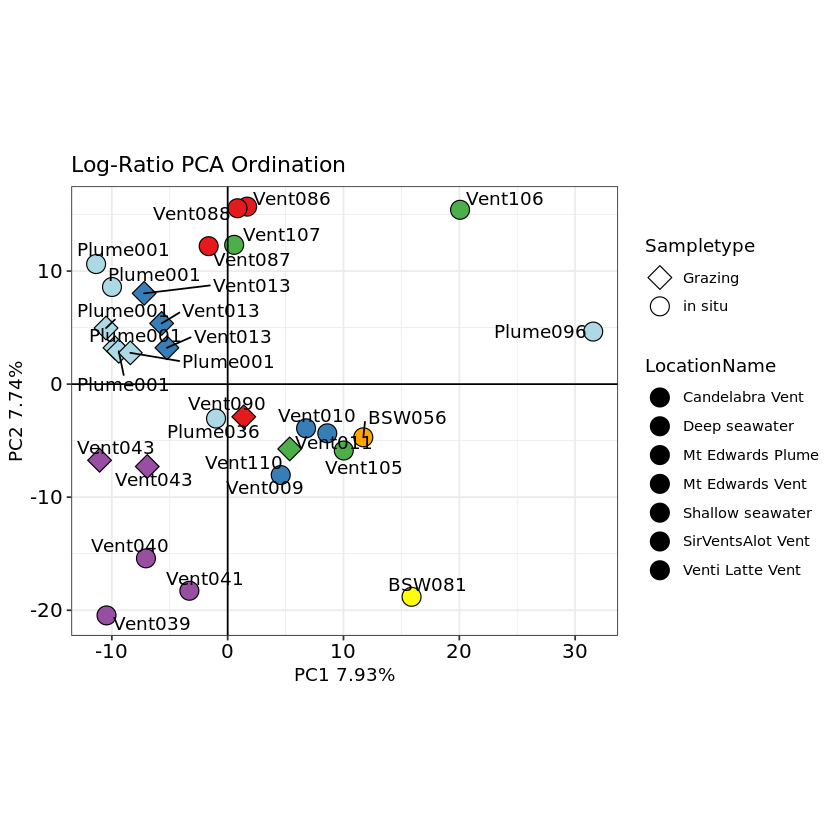

In [11]:
# Extract PCA and plot
pca_lr_frame<-data.frame(pca_lr$x,SAMPLE=rownames(pca_lr$x))
# head(pca_lr_frame)
x <- colsplit(pca_lr_frame$SAMPLE, "_", c("DATASET", "LOCATION", "SAMPLEID", "YEAR", "REP")); pca_lr_frame <- data.frame(x, pca_lr_frame)
head(pca_lr_frame)
ventnames <- read.delim("data-input/ventnames-gordaridge.txt")
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
pca_lr_frame_wNames <- left_join(pca_lr_frame, ventnames, by="SAMPLE")
head(pca_lr_frame_wNames)
#
unique(pca_lr_frame_wNames$LocationName)
sample_order <- c('Mt Edwards Plume','Mt Edwards Vent','Candelabra Vent','SirVentsAlot Vent','Venti Latte Vent','Deep seawater', 'Shallow seawater')
sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "orange", "yellow")
pca_lr_frame_wNames$SAMPLE_ORDER <- factor(pca_lr_frame_wNames$LocationName, levels = rev(sample_order))
names(sample_color)<-sample_order
head(pca_lr_frame_wNames)
#
library(ggrepel)
#
# svg("PCA-wolabels-gr-16-03-2020.svg", w=8, h=8)
ggplot(pca_lr_frame_wNames, aes(x=PC1,y=PC2,fill=LocationName,shape=Sampletype, label=LOCATION_SPECIFIC))+ #Replace label=SAMPLEID.y
  geom_point(aes(x=PC1,y=PC2,fill=LocationName), size=5)+
  scale_fill_manual(values = sample_color)+
  ylab(paste0('PC2 ',round(variance_lr[2]*100,2),'%'))+
  xlab(paste0('PC1 ',round(variance_lr[1]*100,2),'%'))+
  scale_shape_manual(values = c(23,21))+
  ggtitle('Log-Ratio PCA Ordination')+
  coord_fixed(ratio=variance_lr[2]/variance_lr[1])+
  theme_bw()+
  theme(axis.text = element_text(color="black", size=12))+
  geom_hline(yintercept = 0) + geom_vline(xintercept = 0)+
  geom_text_repel()
# dev.off()
# h=815, w=720
#
# 16-03-2020 - last updated SKH

In [13]:
load("data-input/GordaRidge-ASVtable-avg-26-02-2020.RData",verbose = T)
#
# Get binary info - lists from BSW, Plume, Vent, and Grazing
head(gr_counts_avg_wtax[1:2,])
unique(gr_counts_avg_wtax[, c("Sampletype", "LocationName")]) #categories to consider
bin_category <- gr_counts_avg_wtax[, c("Feature.ID", "Sampletype", "LocationName", "COUNT_AVG")]
bin_category$sample_tmp <- paste(bin_category$Sampletype, bin_category$LocationName, sep = "_")
bin_category$sample_tmp <- gsub(" ","_", bin_category$sample_tmp)
head(bin_category)
bin_category$Sampletype<-NULL; bin_category$LocationName <- NULL
head(bin_category)
#
library(reshape2)
bin_wide <- dcast(bin_category, Feature.ID ~ sample_tmp) #aggregate to length is OK - counts occurences
# View(bin_wide)
# row.names(bin_wide) <- bin_wide$Feature.ID; bin_wide$Feature.ID <- NULL
#
head(bin_wide)
# Iteratively select specific ASVs based on these conditions. Generate a new data frame - then these will be compiled
rm(asv_key)
#
shared_all <- bin_wide %>% 
  filter((in_situ_Shallow_seawater > 0 & 
            in_situ_Deep_seawater > 0 &
            in_situ_Mt_Edwards_Plume > 0 &
            Grazing_Mt_Edwards_Plume > 0 &
            in_situ_Mt_Edwards_Vent > 0 &
            Grazing_Mt_Edwards_Vent > 0 &
            in_situ_Venti_Latte_Vent > 0 &
            Grazing_Venti_Latte_Vent > 0 &
            in_situ_Candelabra_Vent > 0 &
            Grazing_Candelabra_Vent > 0 &
            in_situ_SirVentsAlot_Vent > 0 &
            Grazing_SirVentsAlot_Vent > 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "ASV present in all samples") %>%
  data.frame
dim(shared_all)
asv_key <- shared_all
#
bsw_only <- bin_wide %>% 
  filter((in_situ_Shallow_seawater > 0 & 
            in_situ_Deep_seawater > 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "BSW only") %>%
  data.frame
head(bsw_only); dim(bsw_only)
#
asv_key <- rbind(asv_key, bsw_only)
dim(asv_key)
#
shared_edwards <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent > 0 &
            Grazing_Mt_Edwards_Vent > 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
head(shared_edwards); dim(shared_edwards)
#
shared_edwards_wplume <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume > 0 &
            Grazing_Mt_Edwards_Plume > 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
head(shared_edwards_wplume); dim(shared_edwards_wplume)
#
shared_ventilatte <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent > 0 &
            Grazing_Venti_Latte_Vent > 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_ventilatte)
#
shared_candelabra <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent > 0 &
            Grazing_Candelabra_Vent > 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_candelabra)
#
shared_Sirventsalot <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent > 0 &
            Grazing_SirVentsAlot_Vent > 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_Sirventsalot)
#
# Identify ASVs which are unique to a sample
head(bin_wide[1:2,]);names(bin_wide)
tmp_bin <- bin_wide; tmp_bin$SUM <- rowSums(tmp_bin[, 2:13])
tmp_bin2 <- subset(tmp_bin, SUM == 1)
tmp_bin2$CATEGORY <- "Unique to sample"
head(tmp_bin2)
binned_unique <- tmp_bin2[, c("Feature.ID", "CATEGORY")]
length(unique(binned_unique$Feature.ID)); dim(binned_unique)
#
asv_key_2 <- rbind(asv_key, shared_edwards, shared_edwards_wplume, shared_ventilatte, shared_candelabra, shared_Sirventsalot, binned_unique)
dim(asv_key_2); length(unique(asv_key_2$Feature.ID))
#
appears_vent_plume <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in situ vent or plume (not BSW)") %>%
  data.frame
dim(appears_vent_plume)
#
appears_vent <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in situ vent (not BSW or plume)") %>%
  data.frame
dim(appears_vent)
#
appears_deep <- bin_wide %>% 
  filter(((in_situ_Shallow_seawater == 0 & 
             in_situ_Deep_seawater > 0) &
            in_situ_Mt_Edwards_Plume > 0 |
            # Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent > 0 |
            # Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent > 0 |
            # Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent > 0 |
            # Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent > 0 #&
          # Grazing_SirVentsAlot_Vent == 0
  )) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in deep BSW and among vent/plume sites") %>%
  data.frame
dim(appears_deep)

# Regardless of grazing experiment presence:
# Add in this order, will overwrite the previous entry.
dim(appears_deep) # ASV appears BSW and vent and plume
dim(appears_vent_plume) # no BSW, among plume and vent
dim(appears_vent) # no BSW or plume, among vent
#
dim(asv_key_2); unique(asv_key_2$CATEGORY)
#
head(bin_wide)
length(unique(bin_wide$Feature.ID)); dim(bin_wide)
#
# New data frame
asv_key_all <- data.frame(bin_wide[,c("Feature.ID")])
colnames(asv_key_all)[1] <- "Feature.ID"
head(asv_key_all)
deep <- as.character(unique(appears_deep$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% deep] = "ASV appears in BSW and throughout vent/plume"
vent_plume <- as.character(unique(appears_vent_plume$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% vent_plume] = "ASV appears among vent/plume (no BSW)"
vent <- as.character(unique(appears_vent$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% vent] = "ASV appears among vent (no BSW or plume)"
table(asv_key_all$SORTED)
#
asv_key_joined <- left_join(asv_key_all, asv_key_2)
head(asv_key_joined)
asv_key_joined_filled <- data.frame(asv_key_joined, (coalesce(asv_key_joined$CATEGORY, asv_key_joined$SORTED)))
colnames(asv_key_joined_filled)[4] <- "category_final"
table(asv_key_joined_filled$category_final)
# Replace NAs in category_final
asv_key_final <- asv_key_joined_filled[, c("Feature.ID", "category_final")]
str(asv_key_final)
asv_key_final$category_final <- as.character(asv_key_final$category_fina)
asv_key_final$category_final[is.na(asv_key_final$category_fina)] = "Other"
head(asv_key_final)

##  Combine with actual data frame
head(gr_counts_avg_wtax)
gr_sorted <- left_join(gr_counts_avg_wtax, asv_key_final)
head(gr_sorted)
table(gr_sorted$category_final)
#
# Stats
gr_sorted_summary <- gr_sorted %>%
  group_by(SAMPLEID, Sampletype, LocationName, category_final) %>%
  summarise(totalasv = n(), totalseq = sum(COUNT_AVG)) %>%
  data.frame
head(gr_sorted_summary[1:2,])
#
gr_stats <- gr_sorted_summary %>%
  group_by(category_final) %>%
  summarise(totalasvs = sum(totalasv), 
            sumseqs = sum(totalseq)) %>%
  data.frame
gr_stats <- gr_stats %>% mutate(percentseq = sumseqs/sum(sumseqs)*100)

Loading objects:
  gr_counts_filter
  gr_counts_wtax
  gr_counts_avg_wtax


Feature.ID,SAMPLEID,Sampletype,LOCATION_SPECIFIC,LocationName,Taxon,level1,level2,level3,level4,level5,level6,level7,Taxa,COUNT_AVG
0009645516609bda2246e1955ff9ec1d,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,80
0030ad8ce44f257c42daf3673bf92197,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,36


,Sampletype,LocationName
1,in situ,Shallow seawater
3,in situ,Venti Latte Vent
4,in situ,Candelabra Vent
5,Grazing,SirVentsAlot Vent
6,in situ,Deep seawater
8,in situ,Mt Edwards Plume
12,in situ,SirVentsAlot Vent
13,Grazing,Mt Edwards Plume
17,in situ,Mt Edwards Vent
36,Grazing,Mt Edwards Vent


Feature.ID,Sampletype,LocationName,COUNT_AVG,sample_tmp
0009645516609bda2246e1955ff9ec1d,in situ,Shallow seawater,80,in_situ_Shallow_seawater
0030ad8ce44f257c42daf3673bf92197,in situ,Shallow seawater,36,in_situ_Shallow_seawater
0030ad8ce44f257c42daf3673bf92197,in situ,Venti Latte Vent,12,in_situ_Venti_Latte_Vent
0030ad8ce44f257c42daf3673bf92197,in situ,Candelabra Vent,34,in_situ_Candelabra_Vent
0030ad8ce44f257c42daf3673bf92197,Grazing,SirVentsAlot Vent,15,Grazing_SirVentsAlot_Vent
0038478be7fb4f097ce93a5e9341af2a,in situ,Deep seawater,21,in_situ_Deep_seawater


Feature.ID,COUNT_AVG,sample_tmp
0009645516609bda2246e1955ff9ec1d,80,in_situ_Shallow_seawater
0030ad8ce44f257c42daf3673bf92197,36,in_situ_Shallow_seawater
0030ad8ce44f257c42daf3673bf92197,12,in_situ_Venti_Latte_Vent
0030ad8ce44f257c42daf3673bf92197,34,in_situ_Candelabra_Vent
0030ad8ce44f257c42daf3673bf92197,15,Grazing_SirVentsAlot_Vent
0038478be7fb4f097ce93a5e9341af2a,21,in_situ_Deep_seawater


Using sample_tmp as value column: use value.var to override.
Aggregation function missing: defaulting to length


Feature.ID,Grazing_Candelabra_Vent,Grazing_Mt_Edwards_Plume,Grazing_Mt_Edwards_Vent,Grazing_SirVentsAlot_Vent,Grazing_Venti_Latte_Vent,in_situ_Candelabra_Vent,in_situ_Deep_seawater,in_situ_Mt_Edwards_Plume,in_situ_Mt_Edwards_Vent,in_situ_Shallow_seawater,in_situ_SirVentsAlot_Vent,in_situ_Venti_Latte_Vent
0009645516609bda2246e1955ff9ec1d,0,0,0,0,0,0,0,0,0,1,0,0
0030ad8ce44f257c42daf3673bf92197,0,0,0,1,0,1,0,0,0,1,0,1
0038478be7fb4f097ce93a5e9341af2a,0,3,0,0,0,0,1,3,0,1,1,1
003b5938e31a8c1b1809e0358da894e0,0,0,0,0,0,0,0,0,0,1,0,0
003ff3e98dff52952a7036585a32c2f2,0,1,0,0,0,0,0,0,1,0,0,0
004ebe8047915b78deefc412bef467b7,0,0,0,0,0,1,0,0,0,0,0,0


Warning message in rm(asv_key):
“object 'asv_key' not found”

[1] 11  2

Feature.ID,CATEGORY
1a927473fa6e149e5014fe9dd7bc96ad,BSW only
3d9b5f11bd90e3d2ceba3734bd28c45e,BSW only
5928b82237358c9aeea2f71eca990649,BSW only
5afbf523d7ff2ee39b5fa9d8b048dbab,BSW only
e64aa6551dc479e93c6252599700f347,BSW only
e689e56a2c4c1012ce39796a3d916ef9,BSW only


[1] 7 2

[1] 18  2

Feature.ID,CATEGORY
017ac81c155cd604ee9c05a86d886c79,Shared between in situ vent and grazing exp
02b63410473f02428af981eaf3ce7f42,Shared between in situ vent and grazing exp
362a926baf8a439f33402f78fc7027d2,Shared between in situ vent and grazing exp
4a3d1244f2f4ecccc31b35fc1e71b06b,Shared between in situ vent and grazing exp
4b39cf1dc160112de3b825fc68a572ab,Shared between in situ vent and grazing exp
5bf46d9481549878dc6f7ed7b9296df4,Shared between in situ vent and grazing exp


[1] 23  2

Feature.ID,CATEGORY
00b6b6ebc8d3f85c0465683827d97c3e,Shared between in situ vent and grazing exp
06f0a6117862adb2c3f244f7717f8df3,Shared between in situ vent and grazing exp
13061f0b4af345d7f5f954819449903b,Shared between in situ vent and grazing exp
15e457d6eae23bbf03cd11445b6321d2,Shared between in situ vent and grazing exp
16f4468d3bd8aaee86fc400ec7d3a04e,Shared between in situ vent and grazing exp
1e3a7cd269348ae0c380428b64c64f75,Shared between in situ vent and grazing exp


[1] 51  2

[1] 86  2

[1] 11  2

[1] 8 2

Feature.ID,Grazing_Candelabra_Vent,Grazing_Mt_Edwards_Plume,Grazing_Mt_Edwards_Vent,Grazing_SirVentsAlot_Vent,Grazing_Venti_Latte_Vent,in_situ_Candelabra_Vent,in_situ_Deep_seawater,in_situ_Mt_Edwards_Plume,in_situ_Mt_Edwards_Vent,in_situ_Shallow_seawater,in_situ_SirVentsAlot_Vent,in_situ_Venti_Latte_Vent
0009645516609bda2246e1955ff9ec1d,0,0,0,0,0,0,0,0,0,1,0,0
0030ad8ce44f257c42daf3673bf92197,0,0,0,1,0,1,0,0,0,1,0,1


[1] "Feature.ID"                "Grazing_Candelabra_Vent"  
 [3] "Grazing_Mt_Edwards_Plume"  "Grazing_Mt_Edwards_Vent"  
 [5] "Grazing_SirVentsAlot_Vent" "Grazing_Venti_Latte_Vent" 
 [7] "in_situ_Candelabra_Vent"   "in_situ_Deep_seawater"    
 [9] "in_situ_Mt_Edwards_Plume"  "in_situ_Mt_Edwards_Vent"  
[11] "in_situ_Shallow_seawater"  "in_situ_SirVentsAlot_Vent"
[13] "in_situ_Venti_Latte_Vent"

,Feature.ID,Grazing_Candelabra_Vent,Grazing_Mt_Edwards_Plume,Grazing_Mt_Edwards_Vent,Grazing_SirVentsAlot_Vent,Grazing_Venti_Latte_Vent,in_situ_Candelabra_Vent,in_situ_Deep_seawater,in_situ_Mt_Edwards_Plume,in_situ_Mt_Edwards_Vent,in_situ_Shallow_seawater,in_situ_SirVentsAlot_Vent,in_situ_Venti_Latte_Vent,SUM,CATEGORY
1,0009645516609bda2246e1955ff9ec1d,0,0,0,0,0,0,0,0,0,1,0,0,1,Unique to sample
4,003b5938e31a8c1b1809e0358da894e0,0,0,0,0,0,0,0,0,0,1,0,0,1,Unique to sample
6,004ebe8047915b78deefc412bef467b7,0,0,0,0,0,1,0,0,0,0,0,0,1,Unique to sample
7,00597ede505369ed2091643ab495d0d5,0,0,0,0,0,1,0,0,0,0,0,0,1,Unique to sample
8,0059c4a6a0ab3366c3d76ebde6b3a5e6,0,1,0,0,0,0,0,0,0,0,0,0,1,Unique to sample
9,00602acccbd1fe13077829669f662afb,0,0,0,0,0,0,0,0,0,0,1,0,1,Unique to sample


[1] 6807

[1] 6807    2

[1] 7004    2

[1] 7004

[1] 7360    2

[1] 4832    2

[1] 4969    2

[1] 4969    2

[1] 7360    2

[1] 4832    2

[1] 7004    2

[1] "ASV present in all samples"                 
[2] "BSW only"                                   
[3] "Shared between in situ vent and grazing exp"
[4] "Unique to sample"

Feature.ID,Grazing_Candelabra_Vent,Grazing_Mt_Edwards_Plume,Grazing_Mt_Edwards_Vent,Grazing_SirVentsAlot_Vent,Grazing_Venti_Latte_Vent,in_situ_Candelabra_Vent,in_situ_Deep_seawater,in_situ_Mt_Edwards_Plume,in_situ_Mt_Edwards_Vent,in_situ_Shallow_seawater,in_situ_SirVentsAlot_Vent,in_situ_Venti_Latte_Vent
0009645516609bda2246e1955ff9ec1d,0,0,0,0,0,0,0,0,0,1,0,0
0030ad8ce44f257c42daf3673bf92197,0,0,0,1,0,1,0,0,0,1,0,1
0038478be7fb4f097ce93a5e9341af2a,0,3,0,0,0,0,1,3,0,1,1,1
003b5938e31a8c1b1809e0358da894e0,0,0,0,0,0,0,0,0,0,1,0,0
003ff3e98dff52952a7036585a32c2f2,0,1,0,0,0,0,0,0,1,0,0,0
004ebe8047915b78deefc412bef467b7,0,0,0,0,0,1,0,0,0,0,0,0


[1] 9028

[1] 9028   13

Feature.ID
0009645516609bda2246e1955ff9ec1d
0030ad8ce44f257c42daf3673bf92197
0038478be7fb4f097ce93a5e9341af2a
003b5938e31a8c1b1809e0358da894e0
003ff3e98dff52952a7036585a32c2f2
004ebe8047915b78deefc412bef467b7



    ASV appears among vent (no BSW or plume) 
                                        4832 
       ASV appears among vent/plume (no BSW) 
                                        2528 
ASV appears in BSW and throughout vent/plume 
                                         457 

Joining, by = "Feature.ID"


Feature.ID,SORTED,CATEGORY
0009645516609bda2246e1955ff9ec1d,NA,Unique to sample
0030ad8ce44f257c42daf3673bf92197,ASV appears in BSW and throughout vent/plume,NA
0038478be7fb4f097ce93a5e9341af2a,ASV appears in BSW and throughout vent/plume,NA
003b5938e31a8c1b1809e0358da894e0,NA,Unique to sample
003ff3e98dff52952a7036585a32c2f2,ASV appears among vent/plume (no BSW),NA
004ebe8047915b78deefc412bef467b7,ASV appears among vent (no BSW or plume),Unique to sample



    ASV appears among vent (no BSW or plume) 
                                         606 
       ASV appears among vent/plume (no BSW) 
                                         894 
ASV appears in BSW and throughout vent/plume 
                                         446 
                  ASV present in all samples 
                                          11 
                                    BSW only 
                                           7 
 Shared between in situ vent and grazing exp 
                                         179 
                            Unique to sample 
                                        6807 

'data.frame':	9028 obs. of  2 variables:
 $ Feature.ID    : Factor w/ 14483 levels "0009645516609bda2246e1955ff9ec1d",..: 1 5 7 8 9 12 15 16 19 22 ...
 $ category_final: Factor w/ 7 levels "ASV appears among vent (no BSW or plume)",..: 7 3 3 7 2 7 7 7 7 7 ...


Feature.ID,category_final
0009645516609bda2246e1955ff9ec1d,Unique to sample
0030ad8ce44f257c42daf3673bf92197,ASV appears in BSW and throughout vent/plume
0038478be7fb4f097ce93a5e9341af2a,ASV appears in BSW and throughout vent/plume
003b5938e31a8c1b1809e0358da894e0,Unique to sample
003ff3e98dff52952a7036585a32c2f2,ASV appears among vent/plume (no BSW)
004ebe8047915b78deefc412bef467b7,Unique to sample


Feature.ID,SAMPLEID,Sampletype,LOCATION_SPECIFIC,LocationName,Taxon,level1,level2,level3,level4,level5,level6,level7,Taxa,COUNT_AVG
0009645516609bda2246e1955ff9ec1d,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,80
0030ad8ce44f257c42daf3673bf92197,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,36
0030ad8ce44f257c42daf3673bf92197,SUPR,in situ,Vent040,Venti Latte Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,12
0030ad8ce44f257c42daf3673bf92197,SUPR,in situ,Vent088,Candelabra Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,34
0030ad8ce44f257c42daf3673bf92197,T24,Grazing,Vent110,SirVentsAlot Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,15
0038478be7fb4f097ce93a5e9341af2a,sterivex,in situ,BSW056,Deep seawater,Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa,Eukaryota,Opisthokonta,Metazoa,Cnidaria,Cnidaria_X,Hydrozoa,,Opisthokonta-Metazoa,21


Joining, by = "Feature.ID"


Feature.ID,SAMPLEID,Sampletype,LOCATION_SPECIFIC,LocationName,Taxon,level1,level2,level3,level4,level5,level6,level7,Taxa,COUNT_AVG,category_final
0009645516609bda2246e1955ff9ec1d,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,80,Unique to sample
0030ad8ce44f257c42daf3673bf92197,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,36,ASV appears in BSW and throughout vent/plume
0030ad8ce44f257c42daf3673bf92197,SUPR,in situ,Vent040,Venti Latte Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,12,ASV appears in BSW and throughout vent/plume
0030ad8ce44f257c42daf3673bf92197,SUPR,in situ,Vent088,Candelabra Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,34,ASV appears in BSW and throughout vent/plume
0030ad8ce44f257c42daf3673bf92197,T24,Grazing,Vent110,SirVentsAlot Vent,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,15,ASV appears in BSW and throughout vent/plume
0038478be7fb4f097ce93a5e9341af2a,sterivex,in situ,BSW056,Deep seawater,Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa,Eukaryota,Opisthokonta,Metazoa,Cnidaria,Cnidaria_X,Hydrozoa,,Opisthokonta-Metazoa,21,ASV appears in BSW and throughout vent/plume



    ASV appears among vent (no BSW or plume) 
                                        1926 
       ASV appears among vent/plume (no BSW) 
                                        5184 
ASV appears in BSW and throughout vent/plume 
                                        4358 
                  ASV present in all samples 
                                         268 
                                    BSW only 
                                          14 
                                       Other 
                                         205 
 Shared between in situ vent and grazing exp 
                                         546 
                            Unique to sample 
                                        6807 

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)


SAMPLEID,Sampletype,LocationName,category_final,totalasv,totalseq
sterivex,in situ,Deep seawater,ASV appears in BSW and throughout vent/plume,360,19115
sterivex,in situ,Deep seawater,ASV present in all samples,11,1278


`summarise()` ungrouping output (override with `.groups` argument)


In [14]:
LocationNameOrder<-c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent")
gr_sorted_summary$LOCATION_ORDER <- factor(gr_sorted_summary$LocationName, levels = LocationNameOrder)
library(RColorBrewer)

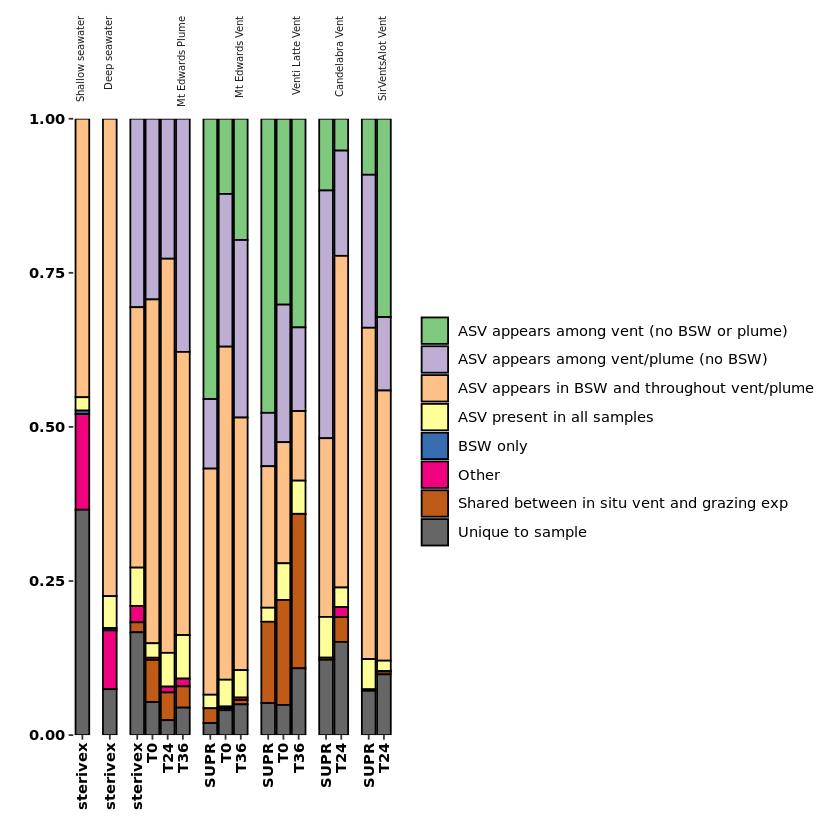

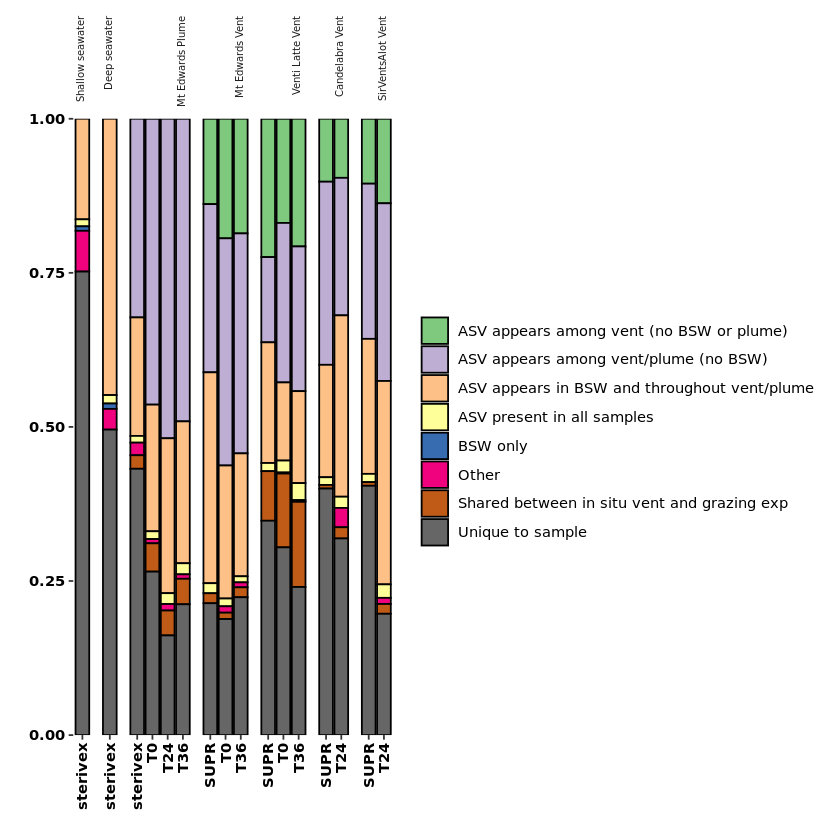

In [16]:
totalseq <- ggplot(gr_sorted_summary, aes(x=SAMPLEID, y=totalseq, fill=category_final)) +
  geom_bar(stat = "identity", color = "black", position = "fill") + 
  scale_fill_brewer(palette = "Accent") +
  scale_y_continuous(expand = c(0, 0)) +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free")+
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 6, angle = 90, vjust = 0, hjust = 1),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
totalseq
#
# plot_grid(totalseq + geom_bar(stat = "identity", color = "black", position = "stack"), totalseq, ncol = 1, nrow = 2, align = "hv")
#
totalasv <- ggplot(gr_sorted_summary, aes(x=SAMPLEID, y= totalasv, fill=category_final)) +
  geom_bar(stat = "identity", color = "black", position = "fill") + 
  scale_fill_brewer(palette = "Accent") +
  scale_y_continuous(expand = c(0, 0)) +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 6, angle = 90, vjust = 0, hjust = 1),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
totalasv
#
# svg("SUPP-asv-distribution-totalseqasv.svg", h=11, w=19)
# plot_grid(totalseq, totalasv)
# plot_grid(totalseq, totalasv,
#           totalseq+
#             geom_bar(stat = "identity", color = "black", position = "stack"), totalasv +
#             geom_bar(stat = "identity", color = "black", position = "stack"))

`summarise()` regrouping output by 'SAMPLE', 'Sampletype', 'LocationName', 'SAMPLEID' (override with `.groups` argument)


[1] Grazing in situ
Levels:  control Control Grazing in situ

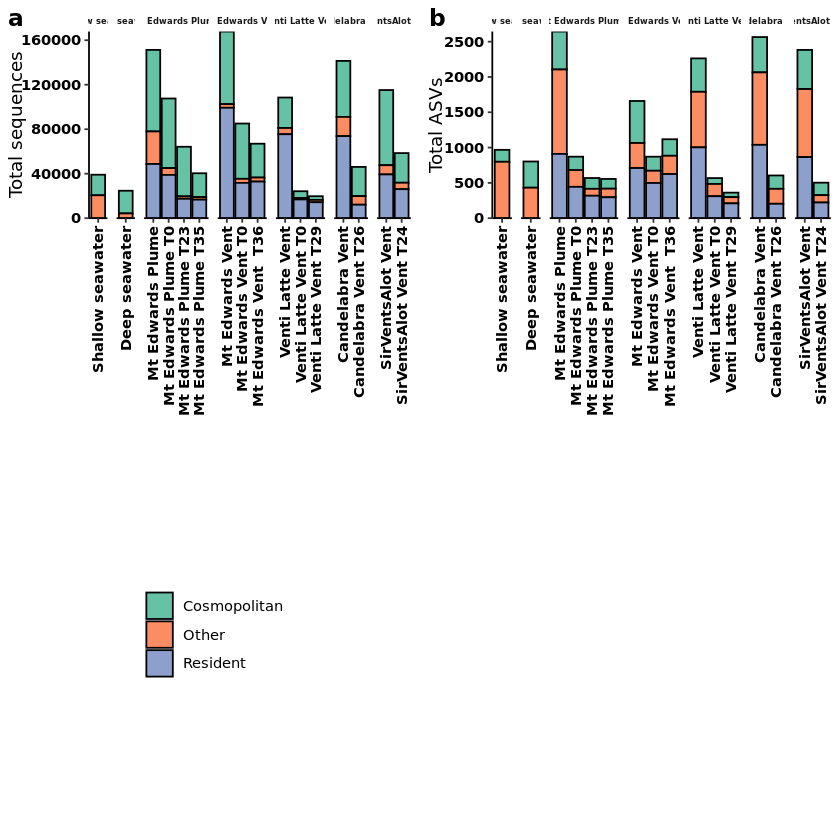

In [17]:
#
# Simplify!
#
resident <- c("ASV appears among vent/plume (no BSW)", "ASV appears among vent (no BSW or plume)", "Shared between in situ vent and grazing exp")
cosmo <- c("ASV appears in BSW and throughout vent/plume", "ASV present in all samples")
gr_sorted$RES_COSMO = "Other"
gr_sorted$RES_COSMO[gr_sorted$category_final %in% resident] = "Resident"
gr_sorted$RES_COSMO[gr_sorted$category_final %in% cosmo] = "Cosmopolitan"
#
# head(gr_sorted[1:2,])
# ?unite()
gr_sorted_bydist <- gr_sorted %>%
  unite("SAMPLE", c("LocationName", "Sampletype", "SAMPLEID"), sep = " ", remove = FALSE) %>%
  group_by(SAMPLE, Sampletype, LocationName, SAMPLEID, RES_COSMO) %>%
  summarise(totalasv = n(), totalseq = sum(COUNT_AVG)) %>%
  data.frame
# head(gr_sorted_bydist)
#
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_sorted_bydist$SAMPLE_ORDER <- factor(gr_sorted_bydist$SAMPLE, levels = sample_order_all, labels = sample_name_all)
#
LocationNameOrder<-c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent")
gr_sorted_bydist$LOCATION_ORDER <- factor(gr_sorted_bydist$LocationName, levels = LocationNameOrder)
unique(gr_sorted_bydist$Sampletype)
#
#
base <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalseq)) +
  geom_bar(stat = "identity", position = "stack", color = "#6a51a3", fill = "#6a51a3") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
#
# ?scale_fill_brewer
# head(gr_sorted_bydist)
filled_seq <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalseq)) +
  geom_bar(stat = "identity", position = "stack", color = "black", aes(fill = RES_COSMO)) +
  scale_fill_brewer(palette = "Set2") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="Total sequences")
#
filled_asv <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalasv)) +
  geom_bar(stat = "identity", position = "stack", color = "black", aes(fill = RES_COSMO)) +
  scale_fill_brewer(palette = "Set2") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="Total ASVs")
#
legend<-get_legend(filled_seq)
# svg("dist-seq-asv.svg", h = 8, w = 10)
plot_grid(filled_seq + theme(legend.position = "none"), 
          filled_asv + theme(legend.position = "none"),
          legend, ncol = 2, nrow = 2, labels = c("a", "b", ""))
# dev.off()

In [ ]:
# save(gr_sorted, asv_key_final, file = "data-input/GR-countinfo-withASVdistribution.RData")

## Generate taxa plots

In [18]:
load("data-input/GordaRidge-ASVtable-avg-26-02-2020.RData",verbose=T)
load("data-input/GR-countinfo-withASVdistribution.RData", verbose=T)

Loading objects:
  gr_counts_filter
  gr_counts_wtax
  gr_counts_avg_wtax
Loading objects:
  gr_sorted
  asv_key_final


In [21]:
# Amend level2 broad taxonomy (based on looking at which groups made up at least 1% of the sequences in a sample):
gr_counts_avg_wtax$LEVEL2 <- gr_counts_avg_wtax$level2
other <- c("Amoebozoa", "Apusozoa", "Excavata")
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$level2 %in% other]="Other"
#
head(gr_counts_avg_wtax[1:2,])
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Alveolata-Ciliates"]="Ciliates"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Alveolata-Dinoflagellates"]="Dinoflagellates"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Opisthokonta-Metazoa"]="Metazoa"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Opisthokonta-Fungi"]="Fungi"
unique(gr_counts_avg_wtax$LEVEL2)
#
# head(gr_counts_avg_wtax)
gr_lev2_avg <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, LEVEL2) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  as.data.frame
# head(gr_lev2_avg)

# Make table to summarize top hits:
gr_lev2_avg_relabun <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, LOCATION_SPECIFIC, level2) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  group_by(SAMPLEID, Sampletype, LocationName, LOCATION_SPECIFIC) %>%
  mutate(RelAbun = 100*(SUM/sum(SUM))) %>%
  as.data.frame
#
gr_lev2_summary <- dcast(gr_lev2_avg_relabun[c(1:5,7)], SAMPLEID + Sampletype + LocationName + LOCATION_SPECIFIC ~level2, fill=0)

Feature.ID,SAMPLEID,Sampletype,LOCATION_SPECIFIC,LocationName,Taxon,level1,level2,level3,level4,level5,level6,level7,Taxa,COUNT_AVG,LEVEL2
0009645516609bda2246e1955ff9ec1d,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,80,Unassigned
0030ad8ce44f257c42daf3673bf92197,sterivex,in situ,BSW081,Shallow seawater,Eukaryota,Eukaryota,Unassigned,,,,,,Unassigned,36,Unassigned


[1] "Unassigned"      "Metazoa"         "Ciliates"        "Opisthokonta"   
 [5] "Stramenopiles"   "Rhizaria"        "Dinoflagellates" "Fungi"          
 [9] "Hacrobia"        "Archaeplastida"  "Other"           "Alveolata"

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)
`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName', 'LOCATION_SPECIFIC' (override with `.groups` argument)
Using RelAbun as value column: use value.var to override.


In [22]:
# Factor for plotting:
# unique(gr_lev2_avg$LEVEL2)
level2ORDER <- c("Dinoflagellates", "Ciliates","Alveolata","Rhizaria", "Hacrobia", "Archaeplastida","Stramenopiles","Metazoa","Fungi","Opisthokonta","Other","Unassigned")
# length(level2ORDER)
level2NAME <- c("Dinoflagellates", "Ciliates","Alveolata-Other","Rhizaria", "Hacrobia", "Archaeplastida","Stramenopiles","Metazoa","Fungi","Opisthokonta-Other","Other","Unassigned")
gr_lev2_avg$LEVEL2ORDER <- factor(gr_lev2_avg$LEVEL2, levels=level2ORDER, labels = level2NAME)

level2color <-c("#e7e1ef", "#df65b0","#980043","#fed976", "#fd8d3c", "#78c679","#238443","#225ea8","#67a9cf","#8c6bb1","#810f7c","#737373")
names(level2color)<-level2NAME
#
# Factor experiment
# unique(gr_lev2_avg$SAMPLEID)
exporder <- c("sterivex", "SUPR", "T0", "T24", "T36")
gr_lev2_avg$SAMPLEID_ORDER <- factor(gr_lev2_avg$SAMPLEID, levels = exporder)
unique(gr_lev2_avg$LocationName)
gr_lev2_avg$LOCATION_ORDER <- factor(gr_lev2_avg$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
# str(gr_lev2_avg)
# head(gr_lev2_avg)
#
gr_lev2_avg$SAMPLE <- paste(gr_lev2_avg$LocationName, gr_lev2_avg$Sampletype, gr_lev2_avg$SAMPLEID_ORDER, sep=" ")
x<-unique(gr_lev2_avg$SAMPLE)
# View(x)
#
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_lev2_avg$sample_order<-factor(gr_lev2_avg$SAMPLE, levels = sample_order_all, labels = sample_name_all)
# head(gr_lev2_avg)
# unique(gr_lev2_avg$LEVEL2ORDER)
#
barplot_lev2 <- function(df){
  ggplot(df, aes(x=(sample_order), y=SUM, fill=LEVEL2ORDER)) +
    geom_bar(stat="identity", position="fill", color="black") +
    scale_fill_manual(values=level2color) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          # axis.line = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
          axis.text.y = element_text(color="black", face="bold"),
          strip.text = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="")+
    facet_grid(.~LOCATION_ORDER, space = "free", scales = "free")
}

[1] Deep seawater     Mt Edwards Plume  Shallow seawater  Candelabra Vent  
[5] Mt Edwards Vent   SirVentsAlot Vent Venti Latte Vent 
12 Levels:  Background Candelabra Vent Deep seawater ... Venti Latte Vent

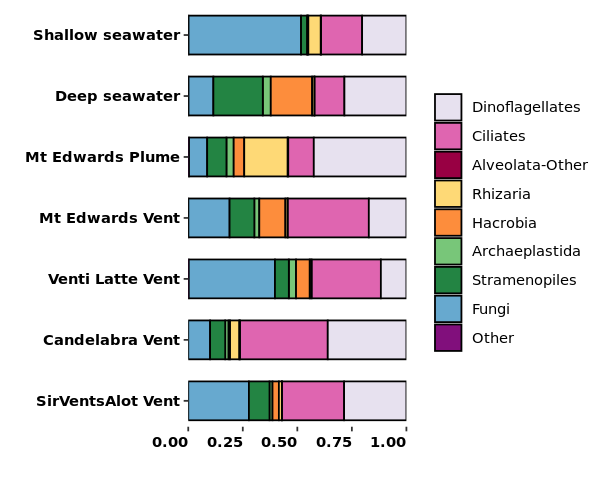

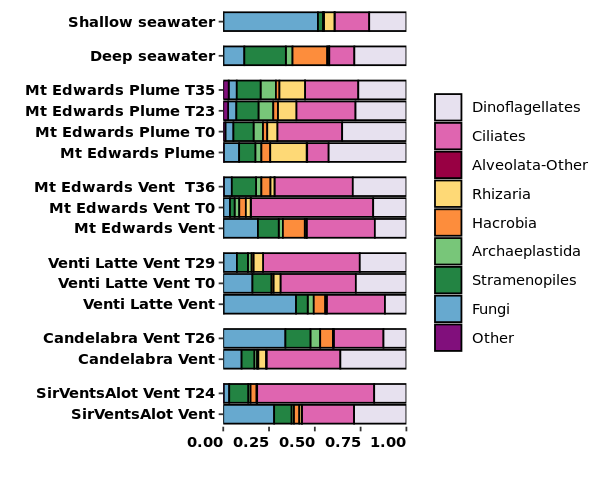

In [31]:
options(repr.plot.width = 5, repr.plot.height = 4) #set plot size output 

insitu <- c("sterivex", "SUPR")
# svg("barplot-insitu-04222020.svg", h = 5, w= 8)
barplot_lev2(subset(gr_lev2_avg, (SAMPLEID %in% insitu & !(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta" | LEVEL2 == "Metazoa")))) + 
  coord_flip() + 
  facet_grid(LOCATION_ORDER ~ ., space = "free", scales = "free") +
  theme(axis.text.x = element_text(color="black", face="bold", angle = 0))
# dev.off()

# svg("barplot-insitu-grazing-04222020.svg", h = 10, w= 8)
barplot_lev2(subset(gr_lev2_avg, (!(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta" | LEVEL2 == "Metazoa")))) + 
  coord_flip() + 
  facet_grid(LOCATION_ORDER ~ ., space = "free", scales = "free") +
  theme(axis.text.x = element_text(color="black", face="bold", angle = 0))
# dev.off()

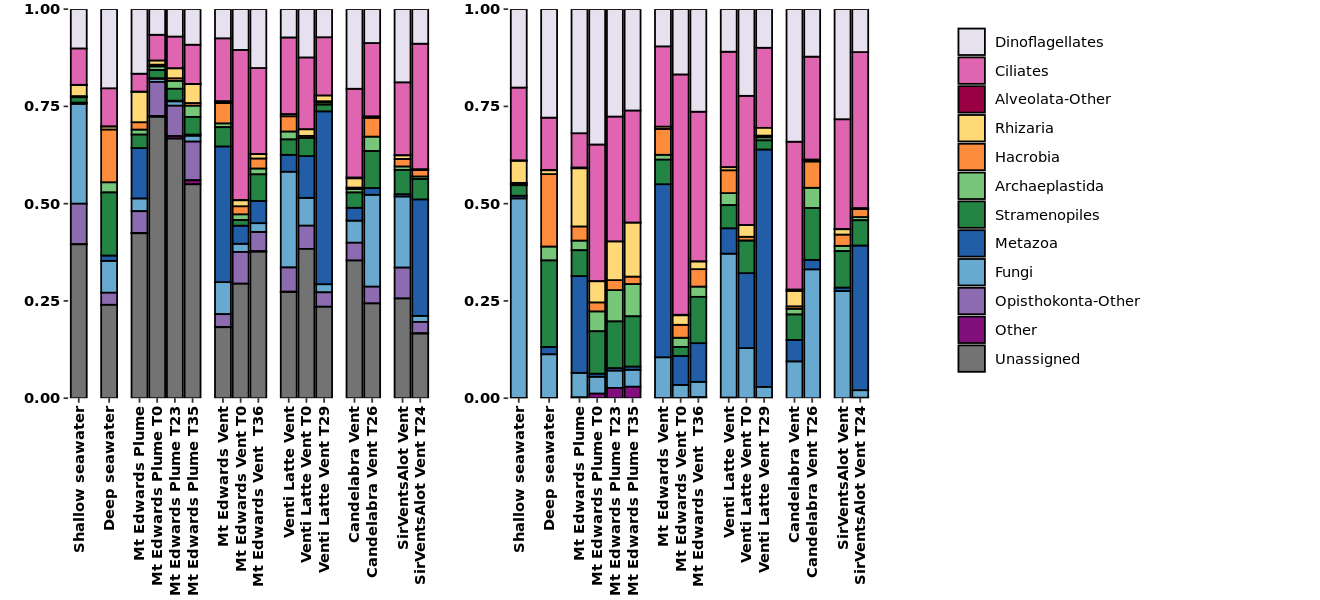

In [27]:
options(repr.plot.width =11, repr.plot.height = 5) #set plot size output 

# With and without unassigned
legend<-get_legend(barplot_lev2(gr_lev2_avg))
# svg("Level2-taxonomy-w-wo-unassigned.svg", h=8, w=23)
plot_grid(
  barplot_lev2(gr_lev2_avg)+theme(legend.position = "none"),
  barplot_lev2(subset(gr_lev2_avg, !(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta")))+theme(legend.position = "none"), legend,
  nrow=1,ncol=3, align="hv", axis="lt", rel_heights = c(1,1))
# dev.off()

## Barplot to additional taxonomic resolution

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)


SAMPLEID,Sampletype,LocationName,Taxa,SUM,TAXA_ORDER,SAMPLE,sample_order,LOCATION_ORDER
sterivex,in situ,Deep seawater,Alveolata-Ciliates,2416,Alveolata-Ciliates,Deep seawater in situ sterivex,Deep seawater,Deep seawater
sterivex,in situ,Deep seawater,Alveolata-Dinoflagellates,5019,Alveolata-Dinoflagellates,Deep seawater in situ sterivex,Deep seawater,Deep seawater


[1] "Alveolata-Ciliates"           "Alveolata-Dinoflagellates"   
 [3] "Alveolata-Other"              "Archaeplastida-Chlorophyta"  
 [5] "Archaeplastida-Other"         "Archaeplastida-Streptophyta" 
 [7] "Hacrobia-Cryptophyta"         "Hacrobia-Haptophyta"         
 [9] "Hacrobia-Katablepharidophyta" "Hacrobia-Other"              
[11] "Opisthokonta-Fungi"           "Opisthokonta-Metazoa"        
[13] "Opisthokonta-Other"           "Rhizaria"                    
[15] "Stramenopiles-Ochrophyta"     "Stramenopiles-Other"         
[17] "Stramenopiles-Pseudofungi"    "Stramenopiles-Sagenista"     
[19] "Unassigned"                   "Other"                       
[21] "Excavata"

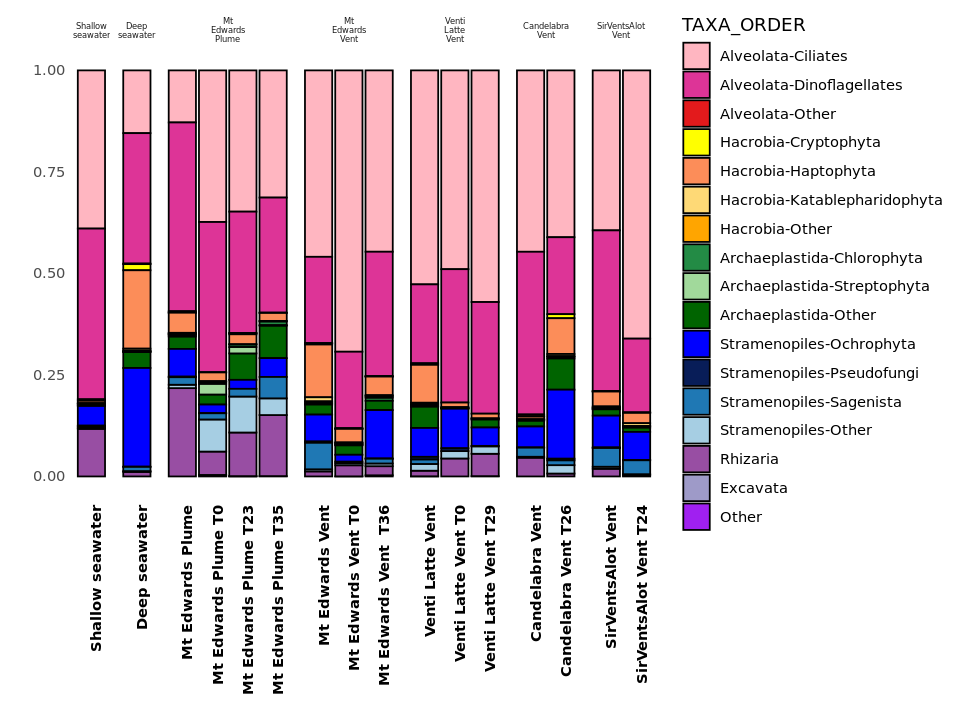

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6) #set plot size output 

gr_lev2_taxres <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, Taxa) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  as.data.frame

# Factor taxa and colors:
tax_order<-c("Alveolata-Ciliates","Alveolata-Dinoflagellates","Alveolata-Other","Hacrobia-Cryptophyta","Hacrobia-Haptophyta","Hacrobia-Katablepharidophyta","Hacrobia-Other","Archaeplastida-Chlorophyta","Archaeplastida-Streptophyta","Archaeplastida-Other","Stramenopiles-Ochrophyta","Stramenopiles-Pseudofungi","Stramenopiles-Sagenista","Stramenopiles-Other","Rhizaria","Excavata","Opisthokonta-Fungi","Opisthokonta-Metazoa","Opisthokonta-Other","Other","Unassigned")
tax_color<-c("lightpink","#dd3497","#e31a1c","yellow","#fc8d59","#fed976","orange","#238b45","#a1d99b","darkgreen","blue","#081d58","#1f78b4","#a6cee3","#984ea3","#9e9ac8","purple","#000000","#525252","#969696","#ffffff")
gr_lev2_taxres$TAXA_ORDER <- factor(gr_lev2_taxres$Taxa, levels = tax_order)
names(tax_order)<-tax_color

# Factor SAMPLID_ORDER
gr_lev2_taxres$SAMPLE <- paste(gr_lev2_taxres$LocationName, gr_lev2_taxres$Sampletype, gr_lev2_taxres$SAMPLEID, sep=" ")
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_lev2_taxres$sample_order<-factor(gr_lev2_taxres$SAMPLE, levels = sample_order_all, labels = sample_name_all)
# exporder <- c("sterivex", "SUPR", "T0", "T24", "T36")
# gr_lev2_taxres$SAMPLEID_ORDER <- factor(gr_lev2_taxres$SAMPLEID, levels = exporder)
# unique(gr_lev2_taxres$LocationName)
gr_lev2_taxres$LOCATION_ORDER <- factor(gr_lev2_taxres$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
#
head(gr_lev2_taxres[1:2,])
#
barplot_tax <- ggplot(gr_lev2_taxres, aes(x=(sample_order), y = SUM, fill = TAXA_ORDER)) +
  geom_bar(stat="identity", position="fill", color="black") +
  scale_fill_manual(values = tax_color) +
  theme_minimal() +
  theme(legend.position = "right", axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, color = "black", face = "bold", hjust = 1, vjust = 1),
        strip.text = element_text(size = 5)) +
  labs(x="", y="") +
facet_grid(.~LOCATION_ORDER, space = "free", scales = "free", labeller = label_wrap_gen(width = 10, multi_line = TRUE))
#
unique(gr_lev2_taxres$Taxa) 
rm<-c("Unassigned", "Opisthokonta-Metazoa", "Opisthokonta-Fungi", "Opisthokonta-Other")
# svg("barplot-tax-all.svg", w = 10, h = 7.5)
barplot_tax %+% subset(gr_lev2_taxres, !(Taxa %in% rm))
# dev.off()